<a href="https://colab.research.google.com/github/MS-2019-Git/EVA4PhaseII/blob/master/S2_MobileNet_V2_Deployment/Session2_TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
#cd '/content/gdrive/My Drive/Session2Dataset_final/OutputData'

In [ ]:
!nvidia-smi

Wed Aug  5 17:58:19 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#cp -av '/content/gdrive/My Drive/Session2Dataset_final/OutputData'  '/content/output'

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
path_on_colab='/content/output'
if not os.path.exists(path_on_colab):
    os.makedirs(path_on_colab)

In [ ]:
#cp -av '/content/gdrive/My Drive/Session2Dataset_final/OutputData'  '/content/output'

In [ ]:
!unzip '/content/gdrive/My Drive/Session2Dataset_final/myzipfile.zip' -d '/content/output'

Streaming output truncated to the last 5000 lines.
 extracting: /content/output/content/gdrive/My Drive/Session2Dataset_final/OutputData/train/Small QuadCopters/back-view-small-compact-drone-flying-against-sun-clear-sky-background-bright-sunny-day-128288117.jpg  
 extracting: /content/output/content/gdrive/My Drive/Session2Dataset_final/OutputData/train/Small QuadCopters/tyumen-russia-june-army-games-engineering-formula-contest-highest-military-engineering-school-ground-military-helicopter-mi-132371776.jpg  
 extracting: /content/output/content/gdrive/My Drive/Session2Dataset_final/OutputData/train/Small QuadCopters/back-view-small-compact-drone-flying-against-sun-clear-sky-background-bright-sunny-day-127905500.jpg  
 extracting: /content/output/content/gdrive/My Drive/Session2Dataset_final/OutputData/train/Small QuadCopters/small-modern-drone-hovering-taking-picture-sunset-small-modern-drone-taking-picture-lake-sunset-112461414.jpg  
 extracting: /content/output/content/gdrive/My Driv

In [ ]:
data_dir = '/content/output/content/gdrive/My Drive/Session2Dataset_final/OutputData'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print (device)

cuda:0


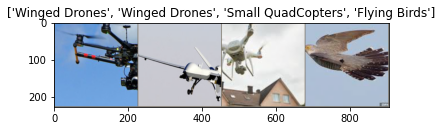

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss/dataset_sizes[phase]
            epoch_acc = running_corrects.double()/dataset_sizes[phase]

            #print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            # Display training updates for the epoch
            phase_duration = time.time() - since
            print(f'{phase.upper()} completed in {phase_duration:.0f}s. '
                  f'Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}')    



        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [ ]:
#model_ft = models.MobileNetV2(pretrained=True)

#from models.imagenet import mobilenetv2
model_ft = models.mobilenet_v2(pretrained=True)
#model_ft = torch.hub.load('pytorch/vision:v0.6.0', 'mobilenet_v2', pretrained=True)
#set_parameter_requires_grad(model_ft, feature_extract)

#num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
#model_ft.fc = nn.Linear(num_ftrs, len(class_names))
print(model_ft.classifier)

model_ft.classifier[1] = nn.Linear(model_ft.last_channel, 4)
print(model_ft.classifier)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth



Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)
Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=4, bias=True)
)


In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=25)
#model_ft.save_state_dict('fine_tuned_best_model.pt')

Epoch 0/24
----------
TRAIN completed in 221s. Loss: 0.7715, Acc: 0.7166
VAL completed in 277s. Loss: 0.4254, Acc: 0.8420

Epoch 1/24
----------
TRAIN completed in 502s. Loss: 0.5398, Acc: 0.8013
VAL completed in 556s. Loss: 0.2995, Acc: 0.8886

Epoch 2/24
----------
TRAIN completed in 782s. Loss: 0.4558, Acc: 0.8314
VAL completed in 839s. Loss: 0.4232, Acc: 0.8321

Epoch 3/24
----------
TRAIN completed in 1069s. Loss: 0.4264, Acc: 0.8442
VAL completed in 1125s. Loss: 0.3086, Acc: 0.8846

Epoch 4/24
----------
TRAIN completed in 1356s. Loss: 0.3970, Acc: 0.8542
VAL completed in 1412s. Loss: 0.2217, Acc: 0.9183

Epoch 5/24
----------
TRAIN completed in 1644s. Loss: 0.3767, Acc: 0.8611
VAL completed in 1701s. Loss: 0.2982, Acc: 0.8975

Epoch 6/24
----------
TRAIN completed in 1926s. Loss: 0.3616, Acc: 0.8686
VAL completed in 1981s. Loss: 0.2663, Acc: 0.9068

Epoch 7/24
----------
TRAIN completed in 2211s. Loss: 0.2819, Acc: 0.8983
VAL completed in 2268s. Loss: 0.2071, Acc: 0.9302

Epoch 

In [ ]:
torch.save(model_ft.state_dict(), 'mobilenetV2.pt')

state_dict = torch.load('mobilenetV2.pt')
model_ft.load_state_dict(state_dict)
#model_ft.save_state_dict('fine_tuned_best_model.pt')

<All keys matched successfully>

In [ ]:
!cp -av '/content/mobilenetV2.pt'  '/content/gdrive/My Drive/Session2Dataset_final'

'/content/mobilenetV2.pt' -> '/content/gdrive/My Drive/Session2Dataset_final/mobilenetV2.pt'
